<a href="https://colab.research.google.com/github/alik604/The-Best-Ensemble/blob/master/The_Best_Ensemble_UNSW_Network_Packet_Classification_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install scikit-plot
!pip install catboost
!pip install mlxtend

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import *
from sklearn.kernel_approximation import Nystroem

from mlxtend.classifier import EnsembleVoteClassifier
import copy

import matplotlib.pyplot as plt
import scikitplot as skplt

import xgboost  # xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
import lightgbm # lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import catboost # catboost.ai/docs/concepts/python-quickstart.html

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id','label'], axis = 1)

In [3]:
columns = combined_data.columns
categorical = ['attack_cat', 'proto', 'service', 'state']

for cat in categorical: 
  encoder = LabelEncoder()
  combined_data[cat] = encoder.fit_transform(combined_data[cat])

In [4]:
y = combined_data['attack_cat']
X = combined_data.drop(['attack_cat'], axis = 1) # inplace = true, to change-in place... mutate origianl data 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42) 

categorical.remove('attack_cat')
train_categorical, test_categorical = X_train[categorical], X_test[categorical] 
X_train, X_test = X_train.drop(categorical, axis=1), X_test.drop(categorical, axis=1)

In [5]:
wanted_explained_variance_ratio = 0.99
steps_down = 2
wanted_n_components = X_train.shape[1]
first_time = True

for i in range(X_train.shape[1]-1, 1, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train).explained_variance_ratio_), 5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False

print("We should set n_components to: ",wanted_n_components)

i = 38 with a variance ratio of 1.0
i = 36 with a variance ratio of 1.0
i = 34 with a variance ratio of 1.0
i = 32 with a variance ratio of 1.0
i = 30 with a variance ratio of 1.0
i = 28 with a variance ratio of 1.0
i = 26 with a variance ratio of 1.0
i = 24 with a variance ratio of 1.0
i = 22 with a variance ratio of 1.0
i = 20 with a variance ratio of 1.0
i = 18 with a variance ratio of 1.0
i = 16 with a variance ratio of 1.0
i = 14 with a variance ratio of 1.0
i = 12 with a variance ratio of 1.0
i = 10 with a variance ratio of 1.0
i = 8 with a variance ratio of 1.0
i = 6 with a variance ratio of 1.0
i = 4 with a variance ratio of 1.0
i = 2 with a variance ratio of 0.99275
We should set n_components to:  39


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=wanted_n_components) # want 26ish to 28ish components, if you want 99% of variance explained
_ = pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [7]:
X_train, X_test = pd.DataFrame(X_train, index = train_categorical.index), pd.DataFrame(X_test, index = test_categorical.index)
X_train, X_test = pd.concat([X_train, train_categorical], axis=1), pd.concat([X_test, test_categorical], axis=1)

In [8]:
DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, random_state=42, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=400, random_state=42, n_jobs=-1, objective='multiclass')

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

## breaks convention, since Nystroem is used
# Linear_SVM = LinearSVC() # 0.77
# feature_map = Nystroem(n_components = 400, gamma= 0.99)
# _ = Linear_SVM.fit(feature_map.fit_transform(X_train), y_train)
# pred = Linear_SVM.score(feature_map.transform(X_test), y_test)
# print("Nystroem on LinearSVC:  %0.7f" %(pred))
# ranking.append(pred)

Acc: 0.72421 for the DecisionTreeClassifier
Acc: 0.77158 for the RandomForestClassifier
Acc: 0.76695 for the ExtraTreesClassifier
Acc: 0.77140 for the XGBClassifier
Acc: 0.77420 for the LGBMClassifier


In [9]:
#CAUTION: Very Expensive
CBC = catboost.CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_seed=42) # loss_function - https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list
CBC.fit(X_train,y_train,eval_set=(X_test, y_test))
pred = CBC.score(X_test,y_test)
name = str(type(CBC)).split(".")[-1][:-2]
print("Acc: %0.5f for the %s" % (pred, name))

ranking.append(pred)
list_of_CLFs.append(CBC)
list_of_CLFs_names.append(name)

Learning rate set to 0.113639
0:	test: 0.8052312	best: 0.8052312 (0)	total: 289ms	remaining: 4m 48s
1:	test: 0.8224792	best: 0.8224792 (1)	total: 524ms	remaining: 4m 21s
2:	test: 0.8255508	best: 0.8255508 (2)	total: 780ms	remaining: 4m 19s
3:	test: 0.8454104	best: 0.8454104 (3)	total: 1.03s	remaining: 4m 16s
4:	test: 0.8479169	best: 0.8479169 (4)	total: 1.27s	remaining: 4m 13s
5:	test: 0.8496885	best: 0.8496885 (5)	total: 1.52s	remaining: 4m 11s
6:	test: 0.8538265	best: 0.8538265 (6)	total: 1.77s	remaining: 4m 11s
7:	test: 0.8580536	best: 0.8580536 (7)	total: 2.03s	remaining: 4m 11s
8:	test: 0.8599265	best: 0.8599265 (8)	total: 2.27s	remaining: 4m 10s
9:	test: 0.8700665	best: 0.8700665 (9)	total: 2.52s	remaining: 4m 9s
10:	test: 0.8724101	best: 0.8724101 (10)	total: 2.77s	remaining: 4m 8s
11:	test: 0.8745851	best: 0.8745851 (11)	total: 3.02s	remaining: 4m 9s
12:	test: 0.8777419	best: 0.8777419 (12)	total: 3.28s	remaining: 4m 9s
13:	test: 0.8792646	best: 0.8792646 (13)	total: 3.53s	rema

In [10]:
best = max(ranking)
avg = sum(ranking)/len(ranking)
variance = avg - best
to_remove = ranking - avg - variance
to_remove_alt = ranking - best - variance

print(list_of_CLFs_names)
print(to_remove)
print(to_remove_alt)

['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']
[-0.02664188  0.02072933  0.01609271  0.02054959  0.02334382  0.02703678]
[-0.04016027  0.00721094  0.00257432  0.0070312   0.00982543  0.01351839]


In [11]:
ranking = np.array(ranking)[to_remove > 0]
list_of_CLFs = np.array(list_of_CLFs)[to_remove > 0]

In [12]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

Acc: 0.77758 for the EnsembleVoteClassifier


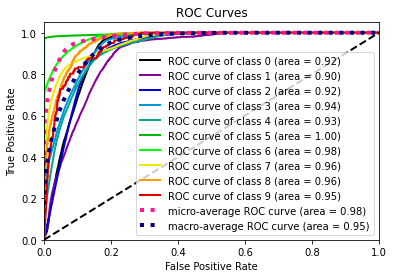

In [13]:
pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
skplt.metrics.plot_roc(y_true=y_test, y_probas=probas)
plt.show()

In [15]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## TODO type check
if type(y_test) is (pd.core.frame.DataFrame or pd.core.series.Series):
  y_test = y_test.values

def benchmark(y_test=y_test, pred=pred, pred_proba=None):
    from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, auc, roc_curve, roc_auc_score, hamming_loss, precision_score, recall_score, f1_score, log_loss

    print("Hamming_loss: \t\t", round(hamming_loss(y_test, pred), 3))                       # HL=1-Accuracy
    print("Precision_score: \t", round(precision_score(y_test, pred, average='micro'), 3))  # tp / (tp + fp)
    print("Recall_score: \t\t", round(recall_score(y_test, pred, average='micro'), 3))      # tp / (tp + fn)
    print("F1 score: \t\t", round(f1_score(y_test, pred, average='micro'), 3))              # 2 * (precision * recall) / (precision + recall)
    print("------------------------------")
    print("Accuracy_score: \t", round(accuracy_score(y_test, pred), 3))
    
    fpr, tpr, _ = roc_curve(y_test == 6, pred == 6)                                         # 6 is "Normal", rest are 'bad'
    print("False Positive Rate - binarized ", fpr)
    print("True Positive Rate  - binarized ", tpr)
    # roc_auc_score(y_test.values, pred, average="micro", multi_class = "ovo")
    print("Area of ROC: \t", round(auc(fpr, tpr), 3))                                       # Apx definite integral... of the ROC
    print("------------------------------")
    if pred_proba is not None: 
      # FYI, `is not` is an operator in it's own right. Like !=.
      print("Log loss (categorical cross entropy): \t", round(log_loss(y_test, pred_proba), 3))   # -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

benchmark(y_test, pred, probas)

sklearn.metrics.multilabel_confusion_matrix(y_test,pred)

Hamming_loss: 		 0.222
Precision_score: 	 0.778
Recall_score: 		 0.778
F1 score: 		 0.778
------------------------------
Accuracy_score: 	 0.778
False Positive Rate - binarized  [0.         0.08860347 1.        ]
True Positive Rate  - binarized  [0.         0.92548713 1.        ]
Area of ROC: 	 0.918
------------------------------
Log loss (categorical cross entropy): 	 0.592


array([[[241284,    956],
        [  2500,     50]],

       [[241738,    837],
        [  2154,     61]],

       [[220580,   8734],
        [ 11025,   4451]],

       [[184227,  18283],
        [ 11103,  31177]],

       [[213820,   7838],
        [ 13067,  10065]],

       [[188655,    298],
        [  1497,  54340]],

       [[142557,  13859],
        [  6585,  81789]],

       [[228147,   3325],
        [  5188,   8130]],

       [[243062,    282],
        [  1168,    278]],

       [[244594,     34],
        [   159,      3]]])